In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os

os.listdir("/kaggle/input")
os.listdir("/kaggle/input/flickr8k")

['captions.txt', 'Images']

In [3]:
# Core
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Image processing
import cv2
import re
import string
from collections import Counter

# Caption processing
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS


# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MultiLabelBinarizer

# Utils
from tqdm import tqdm
import pickle

In [4]:
# Dataset paths
DATASET_DIR = "/kaggle/input/flickr8k"
IMAGE_DIR = os.path.join(DATASET_DIR, "Images")
CAPTION_FILE = os.path.join(DATASET_DIR, "captions.txt")

# Output paths
OUTPUT_DIR = "/kaggle/working"

print("Images:", len(os.listdir(IMAGE_DIR)))
print("Caption file exists:", os.path.exists(CAPTION_FILE))

Images: 8091
Caption file exists: True


In [5]:
# =======================================================
#                1. PRÉTRAITEMENT DES IMAGES
# =======================================================

In [6]:
TARGET_SIZE = (256, 256)

# Variables globales pour les statistiques
image_stats = {
    'total_images': 0, 
    'successful': 0, 
    'failed': 0}

sift_stats = {
    'total_images': 0, 
    'successful': 0, 
    'failed': 0, 
    'total_descriptors': 0, 
    'descriptor_shape': None}

def print_preprocessing_stats():
    print("\n=== Statistiques de prétraitement ===")
    print(f"Total images: {image_stats['total_images']}")
    print(f"Succès: {image_stats['successful']}")
    print(f"Échecs: {image_stats['failed']}")

In [7]:
def preprocess_image(image_path, target_size=TARGET_SIZE, update_stats=True):
    """Prétraite une image unique
    """
    try:
        # 1. Chargement de l'image
        image = cv2.imread(image_path)
        if image is None:
            print(f"Erreur de chargement: {image_path}")
            if update_stats:
                image_stats['failed'] += 1
            return None
        
        # 2. Conversion en niveaux de gris (pour SIFT)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # 3. Redimensionnement
        resized = cv2.resize(gray, target_size, interpolation=cv2.INTER_AREA)
        
        # 4. Normalisation des intensités [0, 255] -> [0, 1]
        normalized = resized / 255.0
        
        if update_stats:
            image_stats['total_images'] += 1
            image_stats['successful'] += 1
                    
        return normalized
        
    except Exception as e:
        print(f"Erreur lors du prétraitement de {image_path}: {e}")
        if update_stats:
            image_stats['failed'] += 1
            image_stats['total_images'] += 1
        return None


def batch_preprocess(image_paths, target_size=(256, 256), show_progress=True):
    """ Prétraite plusieurs images """
    processed_images = []
    
    iterator = tqdm(image_paths) if show_progress else image_paths
    
    for img_path in iterator:
        img = preprocess_image(img_path, target_size, update_stats=True)
        if img is not None:
            processed_images.append(img)
    
    return processed_images

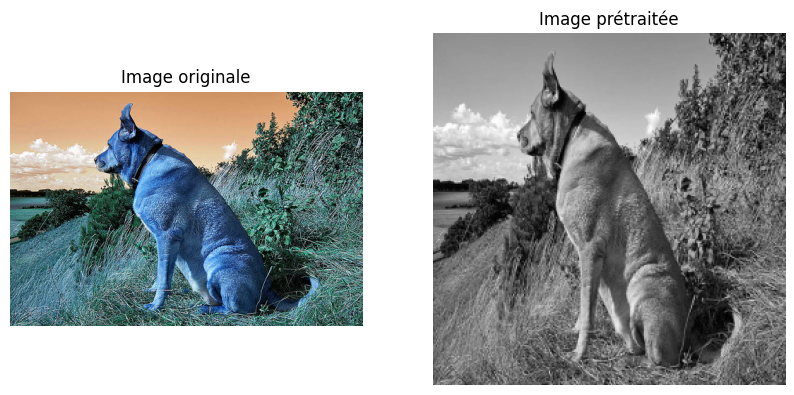

In [8]:
# Chemin vers une image exemple
example_image = "/kaggle/input/flickr8k/Images/1319634306_816f21677f.jpg"

# === Chargement de l'image originale ===
original = cv2.imread(example_image)

# === Prétraitement de l'image exemple ===
processed = preprocess_image(example_image, target_size=TARGET_SIZE)

# --- Affichage avant/après ---
plt.figure(figsize=(10, 5))

# Image originale
plt.subplot(1, 2, 1)
plt.imshow(original)
plt.title("Image originale")
plt.axis("off")

# Image prétraitée
plt.subplot(1, 2, 2)
plt.imshow(processed, cmap='gray')
plt.title("Image prétraitée")
plt.axis("off")

plt.show()

In [9]:
# =======================================================
#                PRÉTRAITEMENT DES CAPTIONS
# =======================================================

In [10]:
# Load captions file
captions_df = pd.read_csv(
    CAPTION_FILE,
    sep=",",
    names=["image", "caption"],
    skiprows=1
)

captions_df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [11]:
STOP_WORDS = set(ENGLISH_STOP_WORDS)

def clean_caption(caption):
    # 1. Conversion en minuscules
    caption = caption.lower()
       
    # 2. Suppression des caractères non alphabétiques
    caption = re.sub(r"[^a-z\s]", "", caption)
        
    # 3. Suppression des espaces multiples
    caption = re.sub(r'\s+', ' ', caption).strip()

    # 4. Tokenization simple avec split
    tokens = caption.split()

    # 5. Suppression des stopwords    
    tokens = [w for w in tokens if w not in STOP_WORDS]

    # 6. Suppression single characters
    tokens = [w for w in tokens if len(w) > 1]
    tokens = ' '.join(tokens)
    
    return tokens


print("=== PREMIÈRES LÉGENDES NETTOYÉES ===")
captions_df["clean_caption"] = captions_df["caption"].apply(clean_caption)
captions_df.head()

=== PREMIÈRES LÉGENDES NETTOYÉES ===


,image,caption,clean_caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,child pink dress climbing set stairs entry way
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,girl going wooden building
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,little girl climbing wooden playhouse
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,little girl climbing stairs playhouse
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,little girl pink dress going wooden cabin


In [12]:
grouped = captions_df.groupby("image")["clean_caption"].apply(list)
print("=== GROUPEMENT PAR IMAGE ===")
grouped.head()

=== GROUPEMENT PAR IMAGE ===


image
1000268201_693b08cb0e.jpg    [child pink dress climbing set stairs entry wa...
1001773457_577c3a7d70.jpg    [black dog spotted dog fighting, black dog tri...
1002674143_1b742ab4b8.jpg    [little girl covered paint sits painted rainbo...
1003163366_44323f5815.jpg    [man lays bench dog sits, man lays bench white...
1007129816_e794419615.jpg    [man orange hat starring, man wears orange hat...
Name: clean_caption, dtype: object

In [13]:
def extract_keywords(captions, min_keywords=3, max_keywords=5):
    """
    Extrait entre 3 et 5 mots-clés par image 
    avec une pondération TF-IDF simple
    """
    
    cleaned_captions = [clean_caption(cap) for cap in captions]

    all_words = []
    for cleaned_cap in cleaned_captions:
        all_words.extend(cleaned_cap.split())
    
    # Calculer TF (Term Frequency)
    word_counts = Counter(all_words)
    total_words = len(all_words)

    # Score TF-IDF simple (avec IDF)
    doc_freq = {}
    for cleaned_cap in cleaned_captions:
        unique_words = set(cleaned_cap.split())
        for word in unique_words:
            doc_freq[word] = doc_freq.get(word, 0) + 1
    
    # Score TF × IDF
    keywords_with_scores = []
    for word, tf in word_counts.items():
        tf_score = tf / total_words
        idf_score = np.log((len(cleaned_captions) + 1) / (doc_freq[word] + 1) ) + 1
        final_score = tf_score * idf_score  # Poids IDF
        keywords_with_scores.append((word, final_score))
        
    # Trier par score
    keywords_with_scores.sort(key=lambda x: x[1], reverse=True)

    # Nombre final de mots (entre 3 et 5)
    n_words = min(max_keywords, max(min_keywords, len(keywords_with_scores)))

    return [word for word, score in keywords_with_scores[:n_words]]


def build_vocabulary(captions_list, min_freq=2):
    """
    Construit un vocabulaire filtré à partir des mots-clés extraits
    avec extract_keywords.
    """
    word_freq = {}

    # captions = iterable de captions par image
    # ex: [[cap1, cap2, cap3], [cap1, cap2], ...]
    for image_captions in captions_list:
        keywords = extract_keywords(image_captions)

        for word in keywords:
            word_freq[word] = word_freq.get(word, 0) + 1

    # Filtrage par fréquence minimale
    vocab = {word for word, freq in word_freq.items() if freq >= min_freq}

    # Tokens spéciaux
    vocab.update(['<PAD>', '<UNK>', '<START>', '<END>'])

    return vocab

In [14]:
image_keywords = grouped.apply(extract_keywords)
print("=== MOTS-CLÉS PAR IMAGE ===")
image_keywords.head()

=== MOTS-CLÉS PAR IMAGE ===


image
1000268201_693b08cb0e.jpg       [girl, climbing, wooden, little, pink]
1001773457_577c3a7d70.jpg            [dog, black, road, dogs, spotted]
1002674143_1b742ab4b8.jpg    [girl, rainbow, little, painted, sitting]
1003163366_44323f5815.jpg               [man, bench, dog, lays, white]
1007129816_e794419615.jpg         [man, hat, glasses, orange, wearing]
Name: clean_caption, dtype: object

In [15]:
# ---- Construire le vocabulaire ----
vocab = build_vocabulary(grouped.values, min_freq=2)
print("Taille du vocabulaire :", len(vocab))
print("Exemples de mots du vocabulaire :", list(vocab)[:20])

Taille du vocabulaire : 1557
Exemples de mots du vocabulaire : ['talking', 'door', 'jet', 'lies', 'broom', 'mask', 'pulling', 'guitar', 'poses', 'held', 'teeth', 'target', 'phone', 'shot', 'stick', 'letters', 'security', 'campsite', 'waterfall', 'professional']


In [16]:
available_images = set(os.listdir(IMAGE_DIR))

image_keywords = image_keywords[
    image_keywords.index.isin(available_images)
]

len(image_keywords)

8091

In [17]:
print("\n=== CHARGEMENT ET PRÉTRAITEMENT DES IMAGES ===")
image_names = list(image_keywords.index)
image_paths = [os.path.join(IMAGE_DIR, img_name) for img_name in image_names]
preprocessed_images = batch_preprocess(image_paths, target_size=TARGET_SIZE, show_progress=True)
print_preprocessing_stats()

print("Number of images to process:", len(image_names))


=== CHARGEMENT ET PRÉTRAITEMENT DES IMAGES ===


100%|██████████| 8091/8091 [02:15<00:00, 59.54it/s]


=== Statistiques de prétraitement ===
Total images: 8092
Succès: 8092
Échecs: 0
Number of images to process: 8091


In [18]:
# =======================================================
#         2. EXTRACTION DES CARACTÉRISTIQUES SIFT
# =======================================================

In [19]:
print("\n" + "="*60)
print("EXTRACTION DES CARACTÉRISTIQUES SIFT")
print("="*60)

descriptors_per_image = []
valid_image_names = []

# Configuration SIFT
SIFT_N_FEATURES = 0  # 0 = illimité
SIFT_CONTRAST_THRESHOLD = 0.04
show_progress = True

# Créer le détecteur SIFT
sift_detector = cv2.SIFT_create(
    nfeatures=SIFT_N_FEATURES,
    contrastThreshold=SIFT_CONTRAST_THRESHOLD
)

# Mettre à jour le nombre total d'images
sift_stats['total_images'] = len(preprocessed_images)

# Boucle principale d'extraction
iterator = tqdm(zip(image_names, preprocessed_images), total=len(image_names)) if show_progress else zip(image_names, preprocessed_images)

for img_name, image in iterator:
    try:
        # RECONVERSION OBLIGATOIRE uint8 pour SIFT
        image_uint8 = (image * 255).astype(np.uint8)
        
        # Détection des keypoints et calcul des descripteurs
        keypoints, descriptors = sift_detector.detectAndCompute(image_uint8, None)
        
        # Traitement des résultats
        if descriptors is not None :
            descriptors_per_image.append(descriptors)
            valid_image_names.append(img_name)
            
            sift_stats['successful'] += 1
            sift_stats['total_descriptors'] += len(descriptors)
                    
            if sift_stats['descriptor_shape'] is None:
                sift_stats['descriptor_shape'] = descriptors.shape[1]
        else:
            print(f"Aucun descripteur trouvé pour: {img_name}")
            sift_stats['failed'] += 1
                
    except Exception as e:
        print(f"Erreur pour {img_name}: {e}")
        sift_stats['failed'] += 1


# ============================================================================
# Affiche les statistiques d'extraction SIFT
# ============================================================================

print("\n=== STATISTIQUES SIFT ===")

print(f"Total d'images: {sift_stats['total_images']}")
print(f"Extraction réussie: {sift_stats['successful']}")
print(f"Extraction échouée: {sift_stats['failed']}")
print(f"Taux de succès: {(sift_stats['successful']/sift_stats['total_images']*100):.2f}%")

if sift_stats['successful'] > 0:
    print(f"Descripteurs totaux: {sift_stats['total_descriptors']}")
    print(f"Moyenne de descripteurs par image: {sift_stats['total_descriptors'] / sift_stats['successful']:.1f}")

print(f"Dimension des descripteurs: {sift_stats['descriptor_shape']}")
print(f"\nExtraction terminée. {len(valid_image_names)} images ont des descripteurs SIFT.")


EXTRACTION DES CARACTÉRISTIQUES SIFT


100%|██████████| 8091/8091 [02:14<00:00, 60.24it/s]


=== STATISTIQUES SIFT ===
Total d'images: 8091
Extraction réussie: 8091
Extraction échouée: 0
Taux de succès: 100.00%
Descripteurs totaux: 3997834
Moyenne de descripteurs par image: 494.1
Dimension des descripteurs: 128

Extraction terminée. 8091 images ont des descripteurs SIFT.


In [20]:
# Compter les labels
all_labels = [label for labels in image_keywords for label in labels]
label_counts = Counter(all_labels)

MIN_FREQ = 10
valid_labels = {l for l, c in label_counts.items() if c >= MIN_FREQ}

# Filtrer les keywords
image_keywords_filtered = image_keywords.apply(
    lambda labels: [l for l in labels if l in valid_labels]
)


mlb = MultiLabelBinarizer()
y = mlb.fit_transform(image_keywords_filtered)


valid_cols = y.sum(axis=0) > 0
y = y[:, valid_cols]

print("Shape of y:", y.shape)
print("Number of classes (keywords):", len(mlb.classes_))

Shape of y: (8091, 495)
Number of classes (keywords): 495


In [21]:
# Save labels
np.save(os.path.join(OUTPUT_DIR, "y_labels.npy"), y)

with open(os.path.join(OUTPUT_DIR, "label_names.pkl"), "wb") as f:
    pickle.dump(mlb.classes_, f)

In [22]:
image_keywords_filtered = image_keywords_filtered.loc[valid_image_names]
y = mlb.transform(image_keywords_filtered)

print("Valid images:", len(valid_image_names))
print("Descriptors list:", len(descriptors_per_image))
print("Labels shape:", y.shape)

Valid images: 8091
Descriptors list: 8091
Labels shape: (8091, 495)


In [23]:
all_descriptors = np.vstack(descriptors_per_image)

print("Total descriptors:", all_descriptors.shape)

Total descriptors: (3997834, 128)


In [24]:
# =======================================================
#         3. Construction d’un dictionnaire visue BoVW
# =======================================================

In [25]:
k = 300
MAX_DESCRIPTORS = 200_000
RANDOM_STATE = 42

if all_descriptors.shape[0] > MAX_DESCRIPTORS:
    idx= np.random.choice(
    all_descriptors.shape[0],
    MAX_DESCRIPTORS,
    replace=False
)
    descriptors_sample = all_descriptors[idx]
else:
    descriptors_sample = all_descriptors

print("Descriptors used for K-Mean : ", descriptors_sample.shape)
kmeans = MiniBatchKMeans(
    n_clusters=k,
    batch_size=10_000,
    random_state=RANDOM_STATE,
    n_init=10
)

kmeans.fit(descriptors_sample)

Descriptors used for K-Mean :  (200000, 128)


MiniBatchKMeans(batch_size=10000, n_clusters=300, n_init=10, random_state=42)

In [26]:
def build_bovw_histogram(descriptors, kmeans, k):
    hist = np.zeros(k)
    clusters = kmeans.predict(descriptors)
    for c in clusters:
        hist[c] += 1
    return hist

In [27]:
X_bovw = []

for des in descriptors_per_image:
    words = kmeans.predict(des)
    hist, _ = np.histogram(words, bins=np.arange(k + 1))
    X_bovw.append(hist)

X_bovw = np.array(X_bovw)

print("BoVW shape:", X_bovw.shape)

BoVW shape: (8091, 300)


In [28]:
# =======================================================
#         4. Réduction de dimension PCA
# =======================================================

In [29]:
PCA_COMPONENTS = 100

pca = PCA(
    n_components=PCA_COMPONENTS,
    random_state=RANDOM_STATE
)

X_pca = pca.fit_transform(X_bovw)

print("PCA shape:", X_pca.shape)

PCA shape: (8091, 100)


In [30]:
explained_variance = np.sum(pca.explained_variance_ratio_)
print("Explained variance:", explained_variance)

Explained variance: 0.7717797495579473


In [31]:
np.save(os.path.join(OUTPUT_DIR, "X_pca.npy"), X_pca)
np.save(os.path.join(OUTPUT_DIR, "y.npy"), y)

with open(os.path.join(OUTPUT_DIR, "image_names.pkl"), "wb") as f:
    pickle.dump(valid_image_names, f)

os.listdir(OUTPUT_DIR)

['.virtual_documents',
 'X_pca.npy',
 'label_names.pkl',
 'y.npy',
 'image_names.pkl',
 'y_labels.npy']

In [32]:
print(X_pca.shape)
print(y.shape)
print(len(mlb.classes_))

(8091, 100)
(8091, 495)
495
